In [41]:
%reset -f

In [42]:
# ~~~~~~~~~~~~~~ Libraries
import sys, os
import mne # Python package for processing and analyzing electrophysiological data
import numpy as np
from glob import glob # look for all the pathnames matching a specified pattern according to the rules
import matplotlib.pyplot as plt
from mne.preprocessing import ICA # ICA (Independent Component Analysis) algorithm, which is for artifact removal
import json
import re

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from itertools import combinations

import pandas as pd
import seaborn as sns
import pickle

import scipy.spatial.distance as dist
import statsmodels.api as sm
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.families.links import Identity  # Updated import

# RDM

In [ ]:
# ~~~~~~~~~~~~~~ Parameters
group = 'adult'
modality = 'visual' # 'visual' or 'audio'

# RDM parameter
whichRDM = 'dynamic' #'dynamic' 

# Print out each parameter
print(f"{modality} data is processed")
print("RDM parameters:")
print(f"  Type: {whichRDM}")
# ~~~~~~~~~~~~~~ Parameters ~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~ Set the working directory
path = f"/u/kazma/MINT/data/{group}/interim/{modality}"
sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"
# ~~~~~~~~~~~~~~ Set the working directory ~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~ Load model RDM
rdm_path = f"/u/kazma/MINT/code/1st-level/RDM"
# Load the .npy file
# Load the .npy file
RDM_numerosity = np.load(f"{rdm_path}/rdm_numerosity.npy")
RDM_spatialfrequency = np.load(f"{rdm_path}/rdm_spatial_frequency.npy")
RDM_signledot = np.load(f"{rdm_path}/rdm_area_of_a_single_dot.npy")
RDM_totaldot = np.load(f"{rdm_path}/rdm_area_of_total_dots.npy")
RDM_circumference = np.load(f"{rdm_path}/rdm_circumference_of_total_dots.npy")
# ~~~~~~~~~~~~~~ Load model RDM ~~~~~~~~~~~~~~


# SUB_LOOP
# for subject in sub_folders_sorted

subject = sub_folders_sorted[0]

# subject folder 
sub_filename = os.path.join(path, subject, 'RDM_epochs-epo.fif') 

# Load epochs
epochs = mne.read_epochs(sub_filename, preload=True)

# Get the information about the data
conditions = list(epochs.event_id.keys())
n_conditions = len(conditions)
# n_trials = len(epochs)
n_channels = epochs.get_data().shape[1]


n_samples = epochs.get_data().shape[2]
min_time = epochs.times[0]*1000   # First time point in milli seconds
max_time = epochs.times[-1]*1000    # Last time point in milli seconds


rdm_order = ['intercept','numerosity_RDM', 'spatialfrequency_RDM', 'signledot_RDM', 'totaldot_RDM', 'circumference_RDM']

betas = np.zeros((len(rdm_order), n_samples)) # 6 = intercept plus betas for each moldel
p_values = np.zeros((len(rdm_order), n_samples)) # 6 = intercept plus betas for each moldel


### Time point LOOP
for timepoint in range(n_samples):

    df_dict = {}

    df = np.zeros((n_conditions, n_channels))

    for i, condition in enumerate(conditions):
        x = epochs[condition]
        x = x.get_data()
        x = x[:,:,timepoint] # because 0 means -100ms, so 50 means the onset
        s = x.reshape(x.shape[0], -1)
        df[i,:] = s
        df_dict[condition] = s


    df_pd = pd.DataFrame(df)
    df_pd.index = list(df_dict.keys())


    # Define the order for conditions
    condition_order = {'singledot': 0, 'totaldot': 1, 'circum': 2}

    df_sort = df_pd.loc[sorted(df_pd.index, key=lambda x: int(x.split('_')[-1].split('.')[0]))]
    df_sort = df_sort.loc[sorted(df_sort.index, key=lambda x: condition_order[x.split('_')[2]])]
    df_sort = df_sort.loc[sorted(df_sort.index, key=lambda x: int(x.split('_')[0]))]


    rdm = dist.pdist(df_sort, metric='correlation')
    rdm_square = dist.squareform(rdm)  
    upper_tri_mask = np.triu(np.ones(rdm_square.shape), k=0).astype(bool) # Create an upper triangular mask (including the diagonal)
    rdm_square[upper_tri_mask] = np.nan   # Apply the mask and set the upper triangle to NaN

    # Min-Max normalization: Normalize the entire matrix
    rdm_minmax_normalized = (rdm_square - np.nanmin(rdm_square)) / (np.nanmax(rdm_square) - np.nanmin(rdm_square))


    # Multiple regressions
    # Multiple regressions
    # vectorize the RDMs
    neural_RDM = rdm_minmax_normalized[np.tril_indices(rdm_minmax_normalized.shape[0], k=-1)]

    numerosity_RDM = RDM_numerosity[np.tril_indices(RDM_numerosity.shape[0], k=-1)]
    spatialfrequency_RDM = RDM_spatialfrequency[np.tril_indices(RDM_spatialfrequency.shape[0], k=-1)]
    signledot_RDM = RDM_signledot[np.tril_indices(RDM_signledot.shape[0], k=-1)]
    totaldot_RDM = RDM_totaldot[np.tril_indices(RDM_totaldot.shape[0], k=-1)]
    circumference_RDM = RDM_circumference[np.tril_indices(RDM_circumference.shape[0], k=-1)]


    Y = neural_RDM
    X = np.column_stack([numerosity_RDM, spatialfrequency_RDM, signledot_RDM, totaldot_RDM, circumference_RDM])
    X = sm.add_constant(X)
    model = sm.GLM(Y, X, family=Gaussian(link=Identity()))
    results = model.fit()

    # print(results.summary())
    coefficient = results.params  # Regression coefficients
    p_value = results.pvalues     # P-values for the coefficients

    betas[:,timepoint] = coefficient # 6 = intercept plus betas for each moldel
    p_values[:,timepoint] = p_value

    print(f"  {subject}: Timepoint {timepoint} proccessed")

### END: Time point LOOP

# convert it into pd.dataframe
betas_pd = pd.DataFrame(betas)
betas_pd.index =  rdm_order

p_values_pd = pd.DataFrame(p_values)
p_values_pd.index =  rdm_order


# ~~~~~~~~~~~~~~~~ Save the decoding accuracy
save_folder = f"/u/kazma/MINT/data/adult/processed/{modality}/{subject}"
save_path = os.path.join(save_folder, "rdm_beta.pkl") #  a pickle file
with open(save_path, "wb") as f:
    pickle.dump(betas_pd, f)
print(f"{subject}: saved in 'rdm_beta.pkl'")

save_path = os.path.join(save_folder, "rdm_beta_pvals.pkl") #  a pickle file
with open(save_path, "wb") as f:
    pickle.dump(p_values_pd, f)
print(f"{subject}: saved in 'rdm_beta_pvals.pkl'")
# ~~~~~~~~~~~~~~~~ Save the decoding accuracy ~~~~~~~~~~~~~~~~

### Supplement

In [ ]:
# ~~~~~~~~~~~~~~ Parameters
group = 'adult'
modality = 'visual' # 'visual' or 'audio'

# RDM parameter
whichRDM = 'static' #'dynamic' 
windowsize = 400 # deviding by considering the sample rate, Target window ms/2

# Print out each parameter
print(f"{modality} data is processed")
print("RDM parameters:")
print(f"  Type: {whichRDM}")
print(f"  window: {windowsize} ms")
# ~~~~~~~~~~~~~~ Parameters ~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~ Set the working directory
path = f"/u/kazma/MINT/data/{group}/interim/{modality}"
sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"
# ~~~~~~~~~~~~~~ Set the working directory ~~~~~~~~~~~~~~

visual data is processed
RDM parameters:
  Type: static
  window: 400 ms


In [ ]:
# SUB_LOOP
# for subject in sub_folders_sorted

subject = sub_folders_sorted[1]

# subject folder 
sub_filename = os.path.join(path, subject, 'RDM_epochs-epo.fif') 

# Load epochs
epochs = mne.read_epochs(sub_filename, preload=True)

# Get the information about the data
conditions = list(epochs.event_id.keys())
n_conditions = len(conditions)
# n_trials = len(epochs)
n_channels = epochs.get_data().shape[1]


n_samples = epochs.get_data().shape[2]
min_time = epochs.times[0]*1000   # First time point in milli seconds
max_time = epochs.times[-1]*1000    # Last time point in milli seconds



Reading /u/kazma/MINT/data/adult/interim/visual/sub-02/RDM_epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
1260 matching events found
No baseline correction applied
0 projection items activated


In [ ]:

df_dict = {}
window = int(windowsize/2)

df = np.zeros((n_conditions, int(n_channels*window)))

for i, condition in enumerate(conditions):
    x = epochs[condition]
    x = x.get_data()
    x = x[:,:,50:window+50] # because 0 means -100ms, so 50 means the onset
    s = x.reshape(x.shape[0], -1)
    df[i,:] = s
    df_dict[condition] = s



In [ ]:
# normalize across channels per time point
# Perform row-wise z-score normalization
mean_vals = np.mean(df, axis=0, keepdims=True)  # Mean per row
std_vals = np.std(df, axis=0, keepdims=True)    # Standard deviation per row

zscore_normalized_data = (df - mean_vals) / std_vals

df_pd = pd.DataFrame(zscore_normalized_data)

df_pd.index = list(df_dict.keys())

In [ ]:
# Define the order for conditions
condition_order = {'singledot': 0, 'totaldot': 1, 'circum': 2}

df_sort = df_pd.loc[sorted(df_pd.index, key=lambda x: int(x.split('_')[-1].split('.')[0]))]
df_sort = df_sort.loc[sorted(df_sort.index, key=lambda x: condition_order[x.split('_')[2]])]
df_sort = df_sort.loc[sorted(df_sort.index, key=lambda x: int(x.split('_')[0]))]



In [ ]:
rdm = dist.pdist(df_sort, metric='correlation')
rdm_square = dist.squareform(rdm)  
upper_tri_mask = np.triu(np.ones(rdm_square.shape), k=0).astype(bool) # Create an upper triangular mask (including the diagonal)
rdm_square[upper_tri_mask] = np.nan   # Apply the mask and set the upper triangle to NaN

In [ ]:
# Min-Max normalization: Normalize the entire matrix
rdm_minmax_normalized = (rdm_square - np.nanmin(rdm_square)) / (np.nanmax(rdm_square) - np.nanmin(rdm_square))


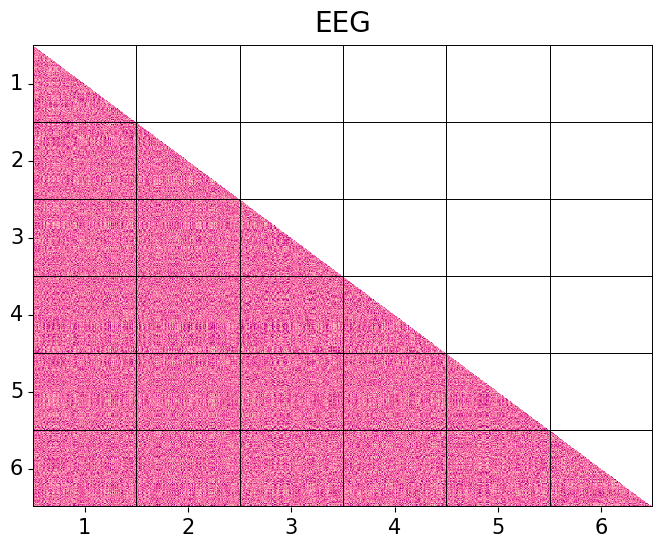

In [ ]:
# ~~~~~~~~~~~~~~~~ RDM visualization
RDM = rdm_minmax_normalized
# paramters
mask = np.triu(np.ones_like(RDM, dtype=bool), k=1)  # Create a mask to show only the lower triangle (or upper triangle if desired), # k=1 means keep the lower triangle, excluding the diagonal
ticks_positions = np.arange((len(conditions)/6) /2, len(conditions), 210).tolist() # Positions in the heatmap corresponding from 1 to 6
ticks_labels = list(range(1,7)) # Labels for the ranges
blackline_positions = np.arange(0, len(conditions), 210).tolist()



# plot and save the figure
plt.figure(figsize=(8, 6))
sns.heatmap(RDM, annot=False, cmap="RdPu", cbar=False, mask=mask)
plt.xticks(ticks=ticks_positions, labels=ticks_labels, rotation=0, fontsize=15)
plt.yticks(ticks=ticks_positions, labels=ticks_labels, fontsize=15)
# Draw horizontal black lines
for _ in blackline_positions:
    plt.axhline(_, color='black', linewidth=0.7)  
    plt.axvline(_, color='black', linewidth=0.7)  
plt.axhline(y=1257, color='black', linewidth=0.7)  
plt.axvline(x=1259, color='black', linewidth=0.7) 

plt.title('EEG', fontsize=20, pad=10)


# save figure and matrix
dir_path = f"/u/kazma/MINT/data/{group}/processed/{modality}/{subject}"
rdm_path = os.path.join(dir_path, 'rdm_eeg.npy')
np.save(rdm_path, RDM)  # Save as .npy

image_path = os.path.join(dir_path, 'rdm_eeg.png')
plt.savefig(image_path, format='png', bbox_inches='tight', pad_inches=0.2)


plt.show()
# ~~~~~~~~~~~~~~~~ RDM visualization ~~~~~~~~~~~~~~~~

## Supplement: Average time series for one channel

In [ ]:

# Set the working directory
path = "/u/kazma/MINT/data/interim/visual"
sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"



for sub_loop in sub_folders_sorted:

    # subject folder 
    sub_filename = os.path.join(path, sub_loop, 'RDM_epochs-epo.fif')

    # Load epochs
    epochs = mne.read_epochs(sub_filename, preload=True)
    print(f"{sub_loop} is analyzed")

    eeg_channels = epochs.pick_types(eeg=True).ch_names
    print("EEG Channels:", eeg_channels)
    print("Number of EEG Channels:", len(eeg_channels))
    
    # Get the condition names
    condition_names = list(epochs.event_id.keys())
    evoked_list = []

    # Compute the averaged epoch for each condition and each channel
    for condition in condition_names:
        evoked = epochs[condition].average()  # Average the epochs for the condition
        evoked_list.append(evoked)

    # Store 6 vectors, representing averaged vector for each condition
    averaged_data = {}

    # Specify the channel to plot (e.g., channel name 'Cz')
    channel_name = 'Fz'  # Replace with the channel of your choice

    # Figure
    plt.figure(figsize=(8, 4))

    # Define colors for the conditions
    colors = plt.cm.tab10(np.linspace(0, 1, 6))

    for i, evoked in enumerate(evoked_list):
        # Extract data for the specified channel
        channel_index = evoked.ch_names.index(channel_name)  # Get index of the channel
        channel_data = evoked.data[channel_index]  # Get the data for the specific channel
        times = evoked.times * 1000  # Convert time to milliseconds

        # Store the data
        averaged_data[condition_names[i]] = channel_data
        
        # Plot the channel data
        plt.plot(times, channel_data, linewidth=3, alpha=0.5) 
        plt.plot(times, channel_data, label=condition_names[i], linewidth=2)  # Plot time series

    # Customize the plot
    plt.title('Average Time Series for Channel: ' + channel_name)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0
    plt.axvline(0, color='black', linestyle='-', linewidth=1)  # Add a vertical line at t=0
    plt.xlim(-20, 900)  # Set x-axis limits
    # plt.ylim(-2.0e-8, 2.0e-8)  # Set y-axis limits
    # plt.legend(ncol=3, loc='lower left', framealpha=1)

    # Set the box line color to gray
    ax = plt.gca()
    ax.spines['top'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    plt.tight_layout()
    plt.show()

